In [1]:
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
# Load anchors (BPG)

anchor_filename = "/home/xyhang/projects/VCIP2023-grand-challenge/experiments/anchors/classa/bpg/results.json"
with open(anchor_filename, "r") as fin:
    anchor_data = json.load(fin)

In [3]:
qps = [13, 17, 21, 25, 29, 33, 37, 41, 45, 49]
bpps_anchor = []
psnrs_anchor = []

for qp in qps:
    bpps_anchor.append(anchor_data[f"qp={qp}"]["level=8"]["IMG_6726"]["bpp"])
    psnrs_anchor.append(anchor_data[f"qp={qp}"]["level=8"]["IMG_6726"]["PSNR"])

In [13]:
# Load main data

import os
from dataclasses import dataclass
import numpy as np


@dataclass
class Data:
    time: float
    psnr: float
    legal: bool
    stage: str
    ans: np.ndarray


levels = range(7)
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]
timepoint = range(0, 600, 10)

base_dir = (
    "/home/xyhang/projects/VCIP2023-grand-challenge/experiments/SAv1/ablation/6K/"
)

# Load bpp info

result_file = "results_ablation.json"

with open(result_file, "r") as f:
    result_data = json.load(f)

In [ ]:
import matplotlib

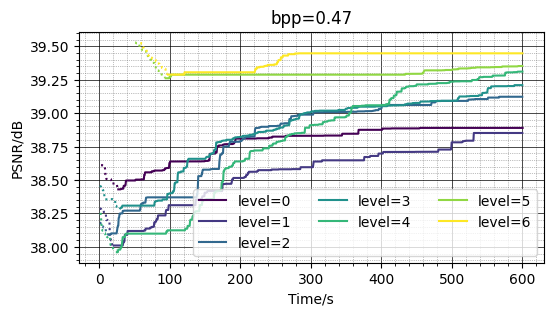

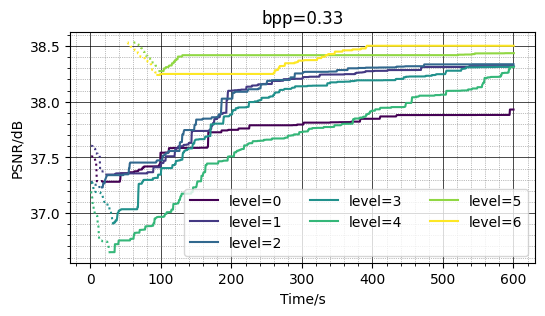

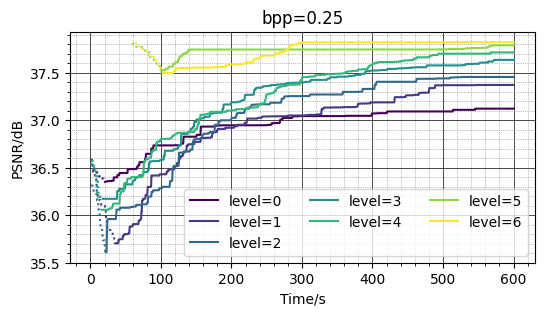

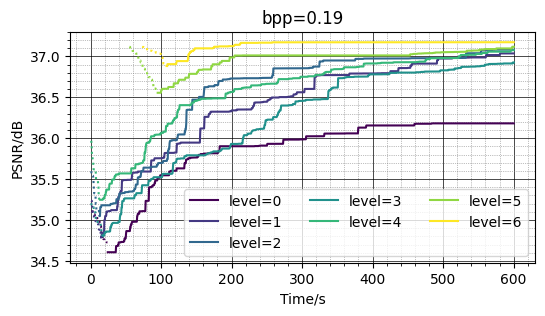

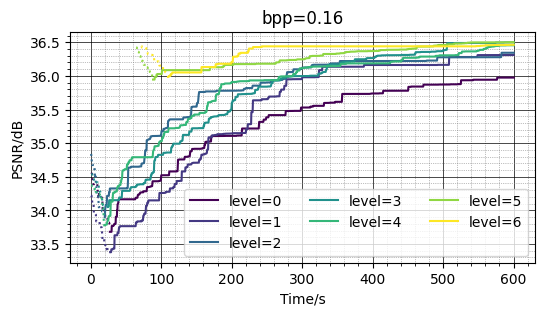

In [132]:
def read_timeline_data(level, qscale):
    jsonfile = os.path.join(base_dir, "PSNR", f"level-{level}", "time_limit-600", f"qscale-{qscale}", "IMG_6726_statistics.json")
    with open(jsonfile, 'r') as f:
        data = json.load(f)
        results = []
        for step_results in data["step_results"]:
            results.append(
                Data(
                    psnr=-step_results["best_loss"],
                    legal=step_results["legal"],
                    time=step_results["time"],
                    stage=step_results["stage"],
                    ans=step_results["best_results"],
                )
            )
        return results

colors = matplotlib.colormaps['viridis'](np.linspace(0, 1, len(levels)))

for qscale in qscales:
    bpp = result_data["level=6"][f"qscale={qscale}"]["avg_bpp"]
    plt.figure(figsize=(6, 3))
    for color, level in zip(colors, levels):
        results = read_timeline_data(level, qscale)
        xs_illegal = [r.time for r in results if not r.legal]
        ys_illegal = [r.psnr for r in results if not r.legal]
        xs_legal = [r.time for r in results if r.legal]
        ys_legal = [r.psnr for r in results if r.legal]
        plt.plot(xs_illegal, ys_illegal, color=color, linestyle=":")
        plt.plot(xs_legal, ys_legal, label=f"level={level}", color=color)
    plt.legend(ncol=3)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.title(f"bpp={bpp:.2f}")
    plt.xlabel("Time/s")
    plt.ylabel("PSNR/dB")
    plt.savefig(f"{qscale}_timeline.pdf", bbox_inches='tight')
    plt.savefig(f"{qscale}_timeline.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [141]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE

timestep = 10

bpps_time = [[[] for i in range(600 // timestep)] for k in range(len(levels))] # 100 200 300 400 500 600
psnrs_time = [[[] for i in range(600 // timestep)] for k in range(len(levels))]
islegal_time = [[[] for i in range(600 // timestep)] for k in range(len(levels))]
ans_time = [[[] for i in range(600 // timestep)] for k in range(len(levels))]

results_bdrate = [[] for k in range(len(levels))]
legals_bdrate = [[] for k in range(len(levels))]
legal_illegal_boundary = []

for i, qscale in enumerate(qscales):
    bpp = result_data["level=6"][f"qscale={qscale}"]["avg_bpp"]
    for j, level in enumerate(levels):
        results = read_timeline_data(level, qscale)
        next_time = timestep
        ind = 0
        for r in results:
            if r.time > next_time:
                bpps_time[j][ind].append(bpp)
                psnrs_time[j][ind].append(r.psnr)
                islegal_time[j][ind].append(r.legal)
                ans_time[j][ind].append(r.ans)
                ind += 1
                next_time += timestep

for i in range(len(levels)):
    for j in range(ind):
        bdrate = BD_RATE(bpps_anchor, psnrs_anchor, bpps_time[i][j], psnrs_time[i][j])
        results_bdrate[i].append(bdrate)
        if (
            j > 0
            and False in islegal_time[i][j - 1]
            and not (False in islegal_time[i][j])
        ):
            legal_illegal_boundary.append(j)

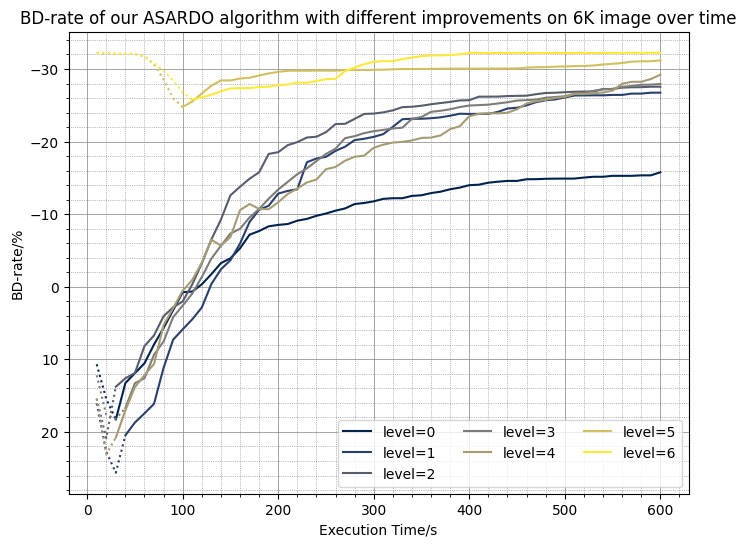

In [140]:
colors = matplotlib.colormaps["cividis"](np.linspace(0, 1, len(levels)))

plt.figure(figsize=(8, 6))
for i in range(len(levels)):
    xs = np.arange(timestep, 600 + timestep, timestep)
    ys = results_bdrate[i]
    boundary = legal_illegal_boundary[i]
    plt.plot(xs[:boundary+1], ys[:boundary+1], linestyle=":", color=colors[i])
    plt.plot(xs[boundary:], ys[boundary:], color=colors[i], label=f"level={i}")
plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel("Execution Time/s")
plt.ylabel(r"BD-rate/%")
plt.title("BD-rate of our ASARDO algorithm with different improvements on 6K image over time")
plt.savefig(f"bdrate_timeline.pdf", bbox_inches="tight")
plt.savefig(f"bdrate_timeline.png", dpi=300, bbox_inches="tight")
plt.show()

In [65]:
results_100 = [
    results_bdrate[i][100 // timestep - 1] - results_bdrate[0][100 // timestep - 1]
    for i in range(7)
]
results_300 = [
    results_bdrate[i][300 // timestep - 1] - results_bdrate[0][300 // timestep - 1]
    for i in range(7)
]
results_600 = [
    results_bdrate[i][600 // timestep - 1] - results_bdrate[0][600 // timestep - 1]
    for i in range(7)
]

print(results_100, results_300, results_600)

[0.0, 5.112302395923862, 1.274324357258183, 1.840244912492217, -0.19894272923890455, -25.521441425891656, -27.524795686391467] [0.0, -8.883670432401237, -12.091185964284056, -9.667231247277806, -7.38658187416843, -18.11198530803052, -19.222710731443236] [0.0, -10.966877791394069, -11.785496232842362, -12.161289950880548, -13.433909832267364, -15.397798193774392, -16.46138342180338]


In [115]:
def make_progressive_plot(data):
    color_positive = 'red'
    color_negative = 'blue'
    data_bottom = [0] + data[:-1]
    data_height = [y-x for x,y in zip(data_bottom, data)]
    plt.figure(figsize=(6, 6))
    for x, y, z in zip(range(len(data)), data_height, data_bottom):
        if y < 0:
            plt.barh(x, y, left=z, color=color_positive, align="center")
        else:
            plt.barh(x, y, left=z, color=color_negative, align="center")
    plt.yticks([])
    plt.ylim(-0.45, 6.45)
    plt.minorticks_on()
    plt.grid(axis="x", which='major')
    plt.grid(axis="x", which="minor", linestyle="--")
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()

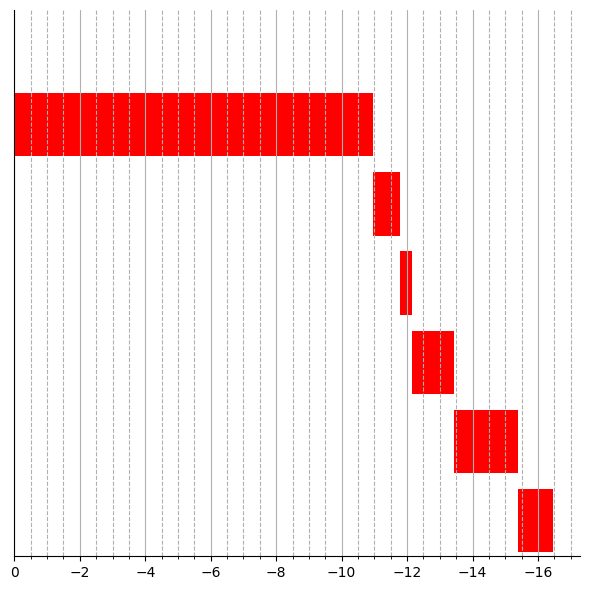

In [116]:
make_progressive_plot(results_100)
plt.savefig("results_bd_100.png", dpi=300)
plt.savefig("results_bd_100.pdf")
plt.close()
make_progressive_plot(results_300)
plt.savefig("results_bd_300.png", dpi=300)
plt.savefig("results_bd_300.pdf")
plt.close()
make_progressive_plot(results_600)
plt.savefig("results_bd_600.png", dpi=300)
plt.savefig("results_bd_600.pdf")

In [104]:
for x in results_100:
    print(f"{x:.2f}%")
for x in results_300:
    print(f"{x:.2f}%")
for x in results_600:
    print(f"{x:.2f}%")

0.00%
5.11%
1.27%
1.84%
-0.20%
-25.52%
-27.52%
0.00%
-8.88%
-12.09%
-9.67%
-7.39%
-18.11%
-19.22%
0.00%
-10.97%
-11.79%
-12.16%
-13.43%
-15.40%
-16.46%


In [147]:
from src.fileio import FileIO

qscale_idx = 0

fileio = FileIO(h=4480, w=6720, ctu_size=512, mosaic=False)

In [149]:
len(fileio.block_indexes)

126

In [175]:
def hex_to_bgr(hex_color):
    # Convert hex to RGB tuple
    hex_color = hex_color.lstrip("#")
    rgb = tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))
    # Convert RGB to BGR
    bgr = (rgb[2], rgb[1], rgb[0])
    return bgr

colors_hex = ["#D6D9D9", "#ADA091", "#6D1E0D", "#A83411", "#39150D", "#C4C78D"]
colors = [hex_to_bgr(color) for color in colors_hex]

In [176]:
colors

[(217, 217, 214),
 (145, 160, 173),
 (13, 30, 109),
 (17, 52, 168),
 (13, 21, 57),
 (141, 199, 196)]

In [191]:
import cv2

def generate_chosen_result_in_img(result):
    image = np.zeros((4480, 6720, 3), np.uint8)
    for i, bb in zip(result, fileio.block_indexes):
        cv2.rectangle(
            image, (bb[1], bb[0]), (bb[3], bb[2]), color=colors[i], thickness=cv2.FILLED
        )
        cv2.rectangle(
            image, (bb[1], bb[0]), (bb[3], bb[2]), color=(0, 0, 0), thickness=10
        )
    return image

In [192]:
for level in levels:
    print(len(ans_time[level]))
    for i in range(4, len(ans_time[level]), 5):
        print(level, i)
        image_raw = generate_chosen_result_in_img(ans_time[level][i][0])
        cv2.imwrite(f'visualize/{level}_{i}.png', image_raw)

60
0 4
0 9
0 14
0 19
0 24
0 29
0 34
0 39
0 44
0 49
0 54
0 59
60
1 4
1 9
1 14
1 19
1 24
1 29
1 34
1 39
1 44
1 49
1 54
1 59
60
2 4
2 9
2 14
2 19
2 24
2 29
2 34
2 39
2 44
2 49
2 54
2 59
60
3 4
3 9
3 14
3 19
3 24
3 29
3 34
3 39
3 44
3 49
3 54
3 59
60
4 4
4 9
4 14
4 19
4 24
4 29
4 34
4 39
4 44
4 49
4 54
4 59
60
5 4
5 9
5 14
5 19
5 24
5 29
5 34
5 39
5 44
5 49
5 54
5 59
60
6 4
6 9
6 14
6 19
6 24
6 29
6 34
6 39
6 44
6 49
6 54
6 59
